# Mental Disorder Classification using Neural Networks

This notebook demonstrates how to build a feed forward neural network (FNN) to classify mental disorders using a dataset from Kaggle.

## Table of Contents
1. [Introduction](#1-introduction)
2. [Data Loading and Preprocessing](#2-data-loading-and-preprocessing)
3. [Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
4. [Neural Network Model](#4-neural-network-model)
5. [Model Evaluation](#5-model-evaluation)
6. [Conclusion and Future Work](#6-conclusion-and-future-work)

## 1. Introduction

This project explores the potential of using a neural network to reverse the traditional diagnostic process for mental health disorders, specifically focusing on Mania Bipolar Disorder, Depressive Bipolar Disorder, Major Depressive Disorder, and individuals who have not been diagnosed. By leveraging a dataset of 120 psychology patients with symptoms, the aim is to determine whether we can accurately diagnose these conditions based on symptoms and behaviors that are not part of the standard DSM-5 diagnostic criteria. Through this approach, we seek to uncover new insights into symptom-based diagnosis using machine learning techniques.

## 2. Data Loading and Preprocessing
Import necessary libraries

In [50]:
# Standard libraries
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
import shap
import sys

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px 
import plotly.subplots as sp
import plotly.graph_objs as go 

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow and Keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint

# Set seeds for reproducibility
np.random.seed(6594)
tf.random.set_seed(6594)

In [51]:
# Import wandb for experiment tracking and logging
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback

# Login to Weights & Biases to track experiments and log metrics
os.environ['WANDB_NOTEBOOK_NAME'] = 'disorder_NN.ipynb'
wandb.login()

wandb: Currently logged in as: zcherry (ch3rry). Use `wandb login --relogin` to force relogin


True

### Read in The Data

In [52]:
# Read in the data
disorders = pd.read_csv("clean_data.csv", index_col='subid')

### Data Preprocessing

In [53]:
# The code transforms binary and ordinal categorical variables into numeric values to facilitate numerical analysis and model input. 
# The focal diagnostic variable remains unchanged to preserve its categorical nature and clarity for interpretation.

# Define the mappings for categorical values
mappings = {
    'binary': {'yes': 0, 'no': 1},
    'multi_class': {'most-often': 0, 'usually': 1, 'sometimes': 2, 'seldom': 3}
}

# Define the columns for each mapping type
binary_columns = [
    'mood_swing', 'suicidal_thoughts', 'anorexia', 'authority_respect', 
    'try_explain', 'aggressive_response', 'ignore_move_on', 'nervous_break_down', 
    'admit_mistakes', 'overthinking'
]

multi_class_columns = [
    'sadness', 'euphoric', 'exhausted', 'sleep_dissorder'
]

# Apply the mappings
disorders.replace({col: mappings['binary'] for col in binary_columns}, inplace=True)
disorders.replace({col: mappings['multi_class'] for col in multi_class_columns}, inplace=True)


In [54]:
# Check to make sure that the changes took effect properly
disorders.head(5)

,sadness,euphoric,exhausted,sleep_dissorder,mood_swing,suicidal_thoughts,anorexia,authority_respect,try_explain,aggressive_response,ignore_move_on,nervous_break_down,admit_mistakes,overthinking,sexual_activity,concentration,optimisim,diagnosis
subid,,,,,,,,,,,,,,,,,,
patient01,1,3,2,2,0,0,1,1,0,1,1,0,0,0,3,3,4,bipolar type-2
patient02,1,3,1,2,1,0,1,1,1,1,1,1,1,1,4,2,5,depression
patient03,2,0,2,2,0,1,1,1,0,0,1,0,0,1,6,5,7,bipolar type-1
patient04,1,3,1,0,0,0,0,1,0,1,1,1,1,1,3,2,2,bipolar type-2
patient05,1,1,2,2,1,1,1,1,1,1,1,0,0,0,5,5,6,no diagnosis


## 3. Exploratory Data Analysis (EDA)

Visualize the distribution of the target variable

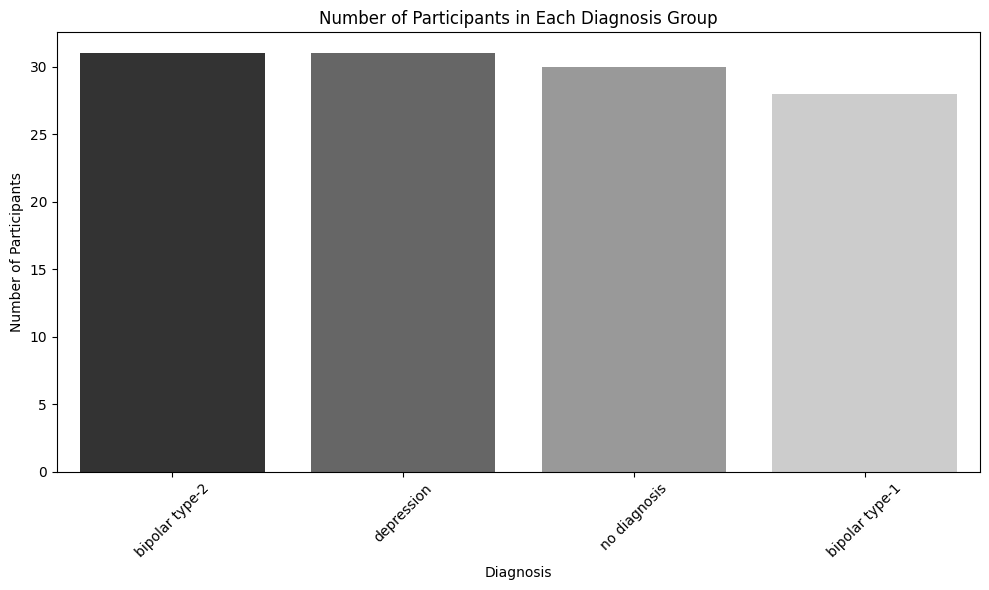

In [55]:
# Count the number of participants in each diagnosis group
diagnosis_counts = disorders['diagnosis'].value_counts()

# Create the bar plot showing the number of individuals in each group
plt.figure(figsize=(10, 6))
sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, palette='grey')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Participants')
plt.title('Number of Participants in Each Diagnosis Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

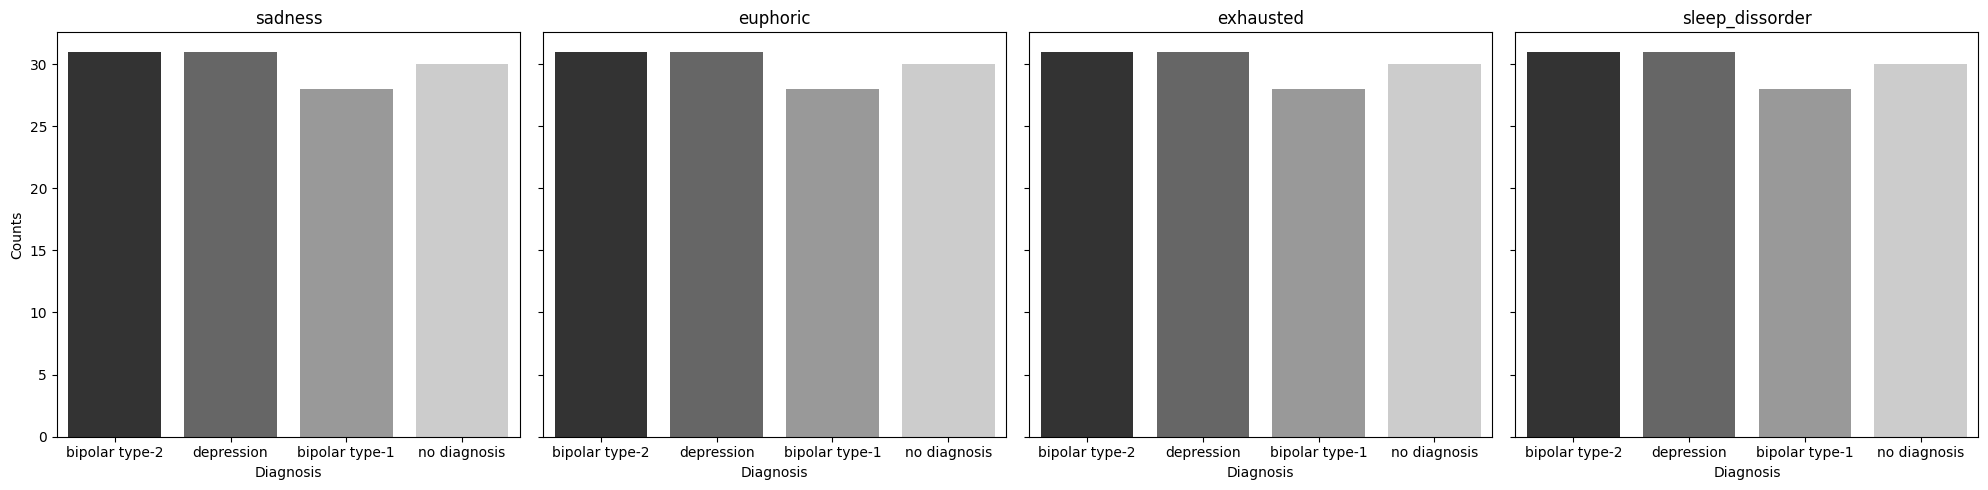

In [78]:
# Melt the DataFrame for FacetGrid
disorders_melted = disorders.melt(id_vars='diagnosis', 
                                  value_vars=multi_class_columns, 
                                  var_name='Category', value_name='Value')

# Plot counts for multiclass variables
fig, axes = plt.subplots(nrows=1, 
                         ncols=len(multi_class_columns), 
                         figsize=(20, 5), 
                         sharey=True)

for ax, col in zip(axes, multi_class_columns):
    sns.countplot(data=disorders_melted[disorders_melted['Category'] == col], 
                  x='diagnosis', 
                  ax=ax,
                  palette='grey')
    ax.set_title(col)
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

### Create The Training and Test Sets

In [57]:
# Separate features and target
X = disorders.drop('diagnosis', axis=1).values
y = disorders['diagnosis'].values

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

# Split the data
x_trn, x_test, y_trn, y_test = train_test_split(x_scaled, y_categorical, test_size=0.2, random_state=6594)

# Examine the distribution of diagnoses in the training set
# Convert y_trn from one-hot encoded format to integer labels
y_trn_labels = np.argmax(y_trn, axis=1)
# Count the occurrences of each diagnosis
label_counts = np.bincount(y_trn_labels)
diagnosis_labels = label_encoder.classes_

#### Examine The Training Set

In [58]:
print("x training is of type " + str(type(x_trn)))
print("y training is of type " + str(type(y_trn)))

print("x training contains data of type " + str(x_trn.dtype))
print("y training contains data of type " + str(y_trn.dtype))

print("x training has shape " + str(x_trn.shape))
print("y training has shape " + str(y_trn.shape))

x training is of type <class 'numpy.ndarray'>
y training is of type <class 'numpy.ndarray'>
x training contains data of type float64
y training contains data of type float64
x training has shape (96, 17)
y training has shape (96, 4)


## 4. Neural Network Model

### Getting The Best Parameters

#### Define the Sweep via Wandb

In [59]:
# Define the sweep
sweep_config = {
    'method': 'random',
    'parameters': {
        'epochs': {'values': [30, 50, 70, 100, 150, 300, 600]},
        'batch_size': {'values': [16, 32, 64, 128]},
        'learning_rate': {'values': [0.0001, 0.001, 0.01, 0.1]},
        'num_layers': {'values': [1, 2, 3]},
        'units_layer_1': {'values': [32, 64, 128, 256]},
        'units_layer_2': {'values': [32, 64, 128, 256]},
        'dropout_rate': {'values': [0.2, 0.3, 0.5, 0.7]},
    }
}

#### Build The Model

In [60]:
# Define the model architecture function
def build_model(config):
    model = Sequential()
    
    # Use config to get parameters
    units_layer_1 = config.units_layer_1
    units_layer_2 = config.units_layer_2
    dropout_rate = config.dropout_rate
    num_layers = config.num_layers
    learning_rate = config.learning_rate
    
    model.add(Dense(units_layer_1, 
                    input_dim=x_trn.shape[1], 
                    activation='relu'))
    model.add(Dropout(dropout_rate))
    
    if num_layers > 1:
        model.add(Dense(units_layer_2, 
                        activation='relu'))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(y_categorical.shape[1], 
                    activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

#### Train The Model

In [61]:
# Define the training function
def train():
    try:
        # Initialize wandb with the project name and configuration
        wandb.init(project="mental-disorder-classification", 
                   config=wandb.config)
        
        model = build_model(wandb.config)
        
        # Define the callbacks
        callbacks = [
            WandbMetricsLogger(log_freq="epoch"),  # Logs metrics every epoch
        ]
        
        history = model.fit(
            x_trn, y_trn,
            validation_data=(x_test, y_test),
            epochs=wandb.config.epochs,
            batch_size=wandb.config.batch_size,
            callbacks=callbacks,
            verbose=0
        )
        
        # Evaluate the model
        loss, accuracy = model.evaluate(x_test, y_test,
                                        verbose=0)
        wandb.log({'validation_loss': loss, 
                   'validation_accuracy': accuracy})
        
    except Exception as e:
        wandb.log({'error': str(e)})
        print(f"An error occurred: {e}")
    finally:
        wandb.finish()

In [ ]:
# Start the sweep
sweep_id = wandb.sweep(sweep_config, 
                       project='mental-disorder-classification')

wandb.agent(sweep_id, function=train)

## 5. Model Evaluation

### Get The Best Model Parameters

In [62]:
import wandb

# Initialize the API
api = wandb.Api()

# Access all runs from the specified project
runs = api.runs('ch3rry/mental-disorder-classification')

# Define the accuracy and loss thresholds
accuracy_min = 0.8
accuracy_max = 0.99
loss_max = 0.3
loss_min = 0.09

# Filter runs based on accuracy and loss criteria
filtered_runs = [
    run for run in runs
    if (accuracy_min <= run.summary.get('validation_accuracy', 0) <= accuracy_max) and
       (loss_min <= run.summary.get('validation_loss', float('inf')) <= loss_max)
]

# Get the best run from the filtered runs based on validation accuracy
if filtered_runs:
    best_run = max(filtered_runs, key=lambda run: run.summary.get('validation_accuracy', 0))
    
    # Access and format the hyperparameters and metrics of the best run
    best_hyperparameters = best_run.config
    validation_accuracy = best_run.summary.get('validation_accuracy')
    validation_loss = best_run.summary.get('validation_loss')
    
    formatted_hyperparameters = {
        'epochs': best_hyperparameters.get('epochs'),
        'batch_size': best_hyperparameters.get('batch_size'),
        'num_layers': best_hyperparameters.get('num_layers'),
        'dropout_rate': best_hyperparameters.get('dropout_rate'),
        'learning_rate': best_hyperparameters.get('learning_rate'),
        'units_layer_1': best_hyperparameters.get('units_layer_1'),
        'units_layer_2': best_hyperparameters.get('units_layer_2'),
    }
    
    # Print the formatted hyperparameters and metrics
    print("Best Hyperparameters and Metrics:")
    for param, value in formatted_hyperparameters.items():
        print(f"    '{param}': {value}")
    print(f"    'validation_accuracy': {validation_accuracy}")
    print(f"    'validation_loss': {validation_loss}")

else:
    print("No runs meet the specified criteria.")


Best Hyperparameters and Metrics:
    'epochs': 150
    'batch_size': 32
    'num_layers': 2
    'dropout_rate': 0.3
    'learning_rate': 0.001
    'units_layer_1': 64
    'units_layer_2': 32
    'validation_accuracy': 0.9583333134651184
    'validation_loss': 0.10998565703630447


For more details on hyperparameters, visit the [project repository](https://wandb.ai/ch3rry/mental-disorder-classification/workspace?nw=nwuserzcherry).

**Note:** Due to the significant number of runs with wandb (over 1,500), runs with unsatisfactory results (high loss/low accuracy) were removed to focus on the most promising models. This approach helps in presenting a cleaner and more relevant set of results.

### Evaluate The Best Model

#### Training The Best Model

In [ ]:
# Define the best hyperparameters
best_hyperparameters = {
    'epochs': 150,
    'batch_size': 32,
    'num_layers': 2,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'units_layer_1': 64,
    'units_layer_2': 32 
}

# Define the model architecture based on the best hyperparameters
def build_best_model():
    model = Sequential()
    
    # First layer
    model.add(Dense(best_hyperparameters['units_layer_1'], input_dim=x_trn.shape[1], activation='relu'))
    model.add(Dropout(best_hyperparameters['dropout_rate']))
    
    # Optional: Add second layer if num_layers > 1
    if best_hyperparameters['num_layers'] > 1:
        model.add(Dense(best_hyperparameters['units_layer_2'], activation='relu'))
        model.add(Dropout(best_hyperparameters['dropout_rate']))
    
    # Add more layers if num_layers > 2
    if best_hyperparameters['num_layers'] > 2:
        model.add(Dense(best_hyperparameters['units_layer_2'], activation='relu'))
        model.add(Dropout(best_hyperparameters['dropout_rate']))

    # Output layer
    model.add(Dense(y_categorical.shape[1], activation='softmax'))
    
    # Compile the model with the best learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build the model
best_model = build_best_model()

best_model.summary()

In [ ]:
# Train the model
h = best_model.fit(
    x_trn, y_trn,  # Training data
    validation_data=(x_test, y_test),  # Validation data
    epochs=best_hyperparameters['epochs'],
    batch_size=best_hyperparameters['batch_size'],
    verbose=0  # Suppress output during training
)

#### Evaluating The Model

In [64]:
# Accuracy/Loss Values in Test Data
loss, accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Loss: {loss}')

Validation Accuracy: 0.9583333134651184
Validation Loss: 0.2010117918252945


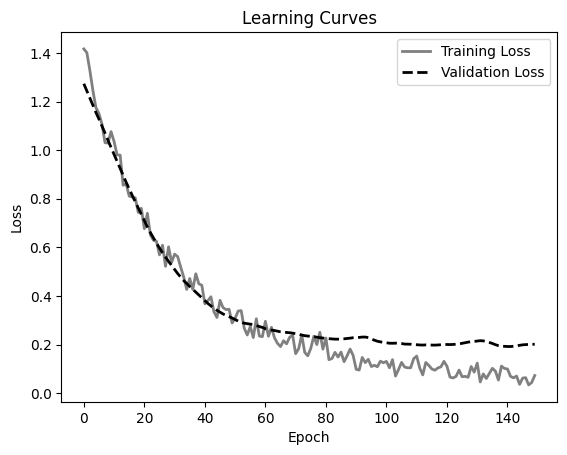

In [82]:
# Loss Plot
plt.figure()
plt.plot(h.history['loss'], label='Training Loss', color='grey', linestyle='-', linewidth=2)  # Solid grey line for training loss
plt.plot(h.history['val_loss'], label='Validation Loss', color='black', linestyle='--', linewidth=2)  # Dashed grey line for validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

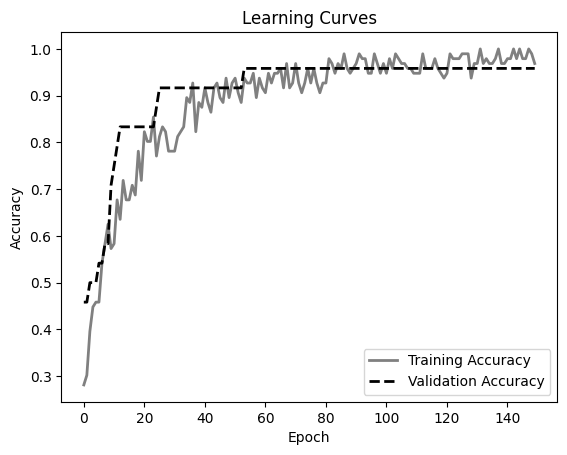

In [83]:
# Accuracy Plot
plt.figure()
plt.plot(h.history['accuracy'], label='Training Accuracy', color='grey', linestyle='-', linewidth=2)  # Solid grey line for training accuracy
plt.plot(h.history['val_accuracy'], label='Validation Accuracy', color='black', linestyle='--', linewidth=2)  # Dashed grey line for validation accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


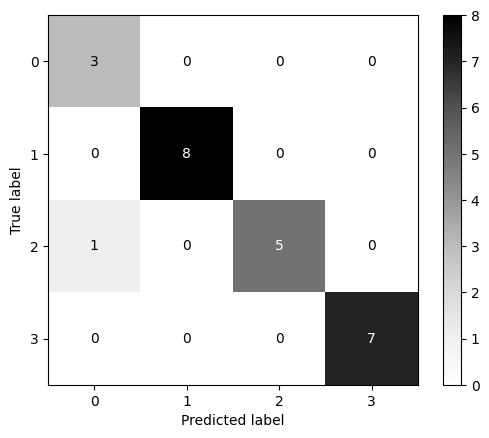

In [86]:
y_pred = np.argmax(best_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greys)
plt.show()

In [89]:
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.96


In [90]:
def per_class_metrics(conf_matrix):
    metrics = {}
    for i in range(conf_matrix.shape[0]):
        true_positives = conf_matrix[i, i]
        false_positives = np.sum(conf_matrix[:, i]) - true_positives
        false_negatives = np.sum(conf_matrix[i, :]) - true_positives
        true_negatives = np.sum(conf_matrix) - (true_positives + false_positives + false_negatives)

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[f"Class {i}"] = {
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_score
        }
    return metrics

metrics = per_class_metrics(cm)
for class_label, metric in metrics.items():
    print(f"{class_label}: Precision = {metric['Precision']:.2f}, Recall = {metric['Recall']:.2f}, F1-Score = {metric['F1-Score']:.2f}")


Class 0: Precision = 0.75, Recall = 1.00, F1-Score = 0.86
Class 1: Precision = 1.00, Recall = 1.00, F1-Score = 1.00
Class 2: Precision = 1.00, Recall = 0.83, F1-Score = 0.91
Class 3: Precision = 1.00, Recall = 1.00, F1-Score = 1.00


## 6. Conclusion and Future Work

The neural network model, optimized with the best hyperparameters, achieved a validation accuracy of 95.83% and a validation loss of 0.1105, demonstrating its potential in diagnosing mental health disorders based on symptoms outside the DSM-5 criteria. This success suggests that machine learning can provide new diagnostic insights. Future work could explore expanding the dataset, experimenting with different neural network architectures, and incorporating additional symptoms or behaviors to further improve the model's accuracy and applicability to diverse populations.